In [1]:
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from tqdm.notebook import trange
%matplotlib notebook

device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [2]:
train_set = CIFAR10(
    download=True,
    root='./dataset',
    train=True,
    transform=ToTensor()
)
test_set = CIFAR10(
    download=True,
    root='./dataset',
    train=False,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>


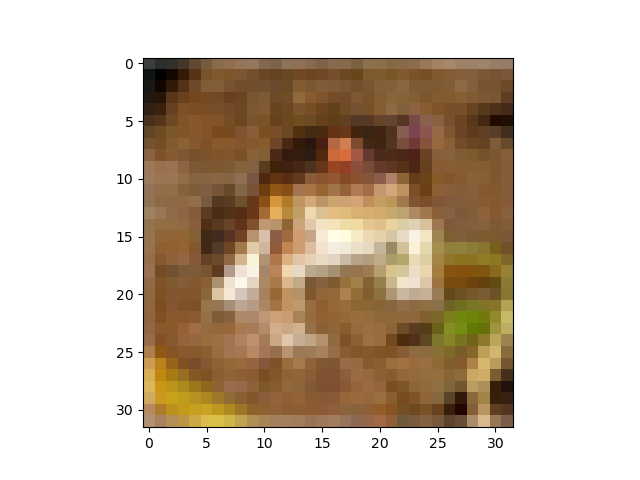

In [3]:
fig, ax = plt.subplots()

def imshow(img, ax=None):
    npimg = img.numpy()
    if ax:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(train_set[0][0], ax)

In [4]:
def get_noise(BS=1):
    return torch.randn(BS, 250, requires_grad=True).to(device)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(1, 56, 5, padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(56, 128, 5, padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 3, 5, padding=2),
            nn.Sigmoid()
        )
        self.linear = nn.Sequential(
            nn.BatchNorm1d(250),
            nn.Linear(250, 500),
            nn.Dropout(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 32*32),
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(-1, 1, 32, 32)
        return self.conv(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 128, 5, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(128, 56, 5, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(56, 1, 5, padding=2),
            nn.LeakyReLU()
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(32*32),
            nn.Linear(32*32, 500),
            nn.Dropout(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 250),
            nn.LeakyReLU(),
            nn.Linear(250, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        return self.linear(x)

In [7]:
train_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
D = Discriminator().to(device)
G = Generator().to(device)

try:
    d_checkpoint = torch.load('./checkpoints/discriminator.pt')
    g_checkpoint = torch.load('./checkpoints/generator.pt')

    D.load_state_dict(d_checkpoint['model_state_dict'])
    G.load_state_dict(g_checkpoint['model_state_dict'])

except FileNotFoundError:
    pass

<IPython.core.display.Javascript object>


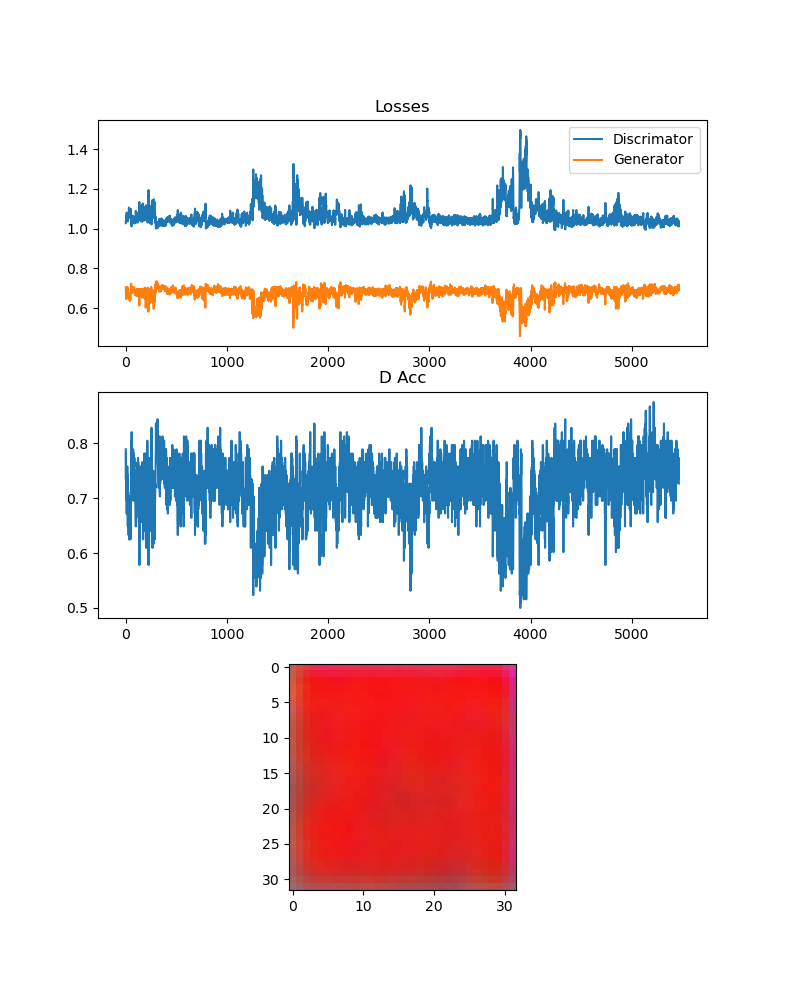

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
BS = 64
train_dtld = DataLoader(train_set, batch_size=BS, num_workers=1, drop_last=True)

optim_D = torch.optim.Adam(D.parameters(), lr=4e-5)
optim_G = torch.optim.Adam(G.parameters(), lr=1e-5)

loss_fn = nn.BCELoss()

epochs = 10

d_losses = []
d_acc = []
g_losses = []

fig, axs = plt.subplots(3)
fig.set_size_inches((7.85, 10))

for epoch in (t:=trange(epochs)):    
    for (X, _) in train_dtld:
        X = X.to(device)
        Z = get_noise(BS)
        real_pred = D(X)
        fake_pred = D(G(Z).detach())

        # Update discriminator
        real_loss = loss_fn(real_pred, torch.full_like(real_pred, .9))
        fake_loss = loss_fn(fake_pred, torch.zeros_like(fake_pred))
        
        d_loss = real_loss + fake_loss
        d_losses.append(d_loss.item())
    
        d_loss.backward()
        optim_D.step()
        
        for p in D.parameters():
            p.grad = None
        
        ## Calc D acc
        real_labels = torch.squeeze(torch.round(real_pred)).detach().cpu()
        fake_labels = torch.squeeze(torch.round(fake_pred)).detach().cpu()
        
        correct_labels = torch.count_nonzero(real_labels) + \
            len(fake_labels) - torch.count_nonzero(fake_labels)

        total_labels = len(real_labels) + len(fake_labels)
        d_acc.append(correct_labels / total_labels)
            
        # Update generator
        fake_pred = D(G(Z))
        g_loss = loss_fn(fake_pred, torch.ones_like(fake_pred))
        g_losses.append(g_loss.item())
        
        g_loss.backward()
        optim_G.step()
        
        for p in G.parameters():
            p.grad = None
                    
    for ax in axs:
        ax.clear()
    
    axs[0].plot(d_losses, label='Discrimator')
    axs[0].plot(g_losses, label='Generator')
    axs[0].set_title('Losses')
    axs[0].legend()
    axs[1].plot(d_acc)
    axs[1].set_title('D Acc')
    imshow(G(get_noise(BS=2))[0].detach().cpu() / 2 + 0.5, ax=axs[2])
    
    fig.canvas.draw()

<IPython.core.display.Javascript object>


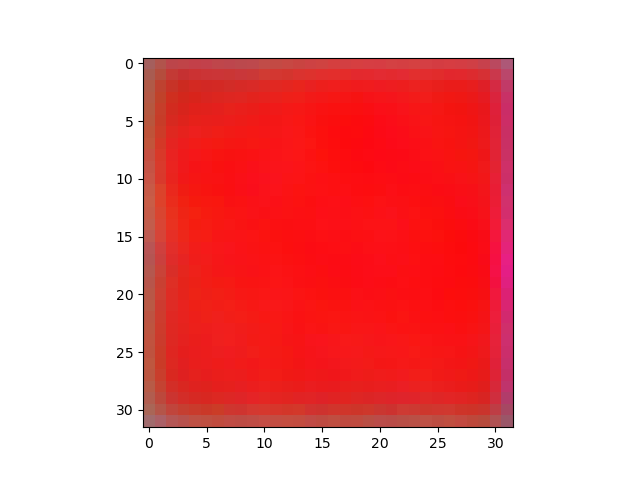

In [13]:
fig, ax = plt.subplots()
imshow(G(get_noise(BS=2))[0].detach().cpu() / 2 + 0.5, ax=ax)

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': optim_D.state_dict(),
            'loss': d_losses[-1]
            }, './checkpoints/discriminator.pt')

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': optim_G.state_dict(),
            'loss': g_losses[-1]
            }, './checkpoints/generator.pt')